In [191]:
import glob

import numpy as np
from pylab import *
%matplotlib inline

def read_ps_voltage(file):
    read_data = np.genfromtxt(file, skip_header=1, delimiter=',')
    return read_data[:, 1]

# Messungen

Wir haben angefangen 20 verschiedene Entfernungen zu messen und diese mit der Picoscope Software in 20 einzelne CSV Dateien gespeichert.


In [192]:
files = glob.glob("cleaned/*cm*.csv")

# [reference in mm, all voltage values]
data = {
    100: read_ps_voltage(files[0]),
    130: read_ps_voltage(files[1]),
    160: read_ps_voltage(files[2]),
    180: read_ps_voltage(files[3]),
    220: read_ps_voltage(files[4]),
    245: read_ps_voltage(files[5]),
    250: read_ps_voltage(files[6]),
    280: read_ps_voltage(files[7]),
    300: read_ps_voltage(files[8]),
    340: read_ps_voltage(files[9]),
    380: read_ps_voltage(files[10]),
    410: read_ps_voltage(files[11]),
    460: read_ps_voltage(files[12]),
    490: read_ps_voltage(files[13]),
    520: read_ps_voltage(files[14]),
    580: read_ps_voltage(files[15]),
    620: read_ps_voltage(files[16]),
    650: read_ps_voltage(files[17]),
    # 690: read_ps_voltage(files[18]),
    # 710: read_ps_voltage(files[19]),
}

data_mean = {k: np.mean(v) for k, v in data.items()}

measurements = np.array(list(data_mean.items()))
distances = measurements[:, 0]
voltages = measurements[:, 1]

# Plotten und Logarithm

Wir können jetzt diese daten plotten. Sie haben die form $y = x^a$ deswegen müssen wir sie logarithmieren.


Text(0.5, 0, 'Voltage')

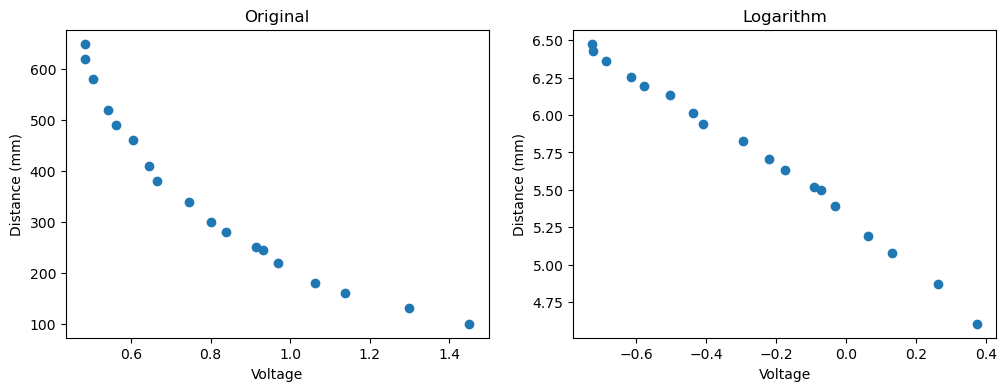

In [209]:
fig, (ax1, ax2) = plt.subplots(1,2)
fig.set_size_inches(12, 4)

ax1.scatter(voltages, distances)
ax1.set_title("Original")
ax1.set_ylabel("Distance (mm)")
ax1.set_xlabel("Voltage")

log_distances = np.log(distances)
log_voltages = np.log(voltages)

ax2.scatter(log_voltages, log_distances)
ax2.set_title("Logarithm")
ax2.set_ylabel("Distance (mm)")
ax2.set_xlabel("Voltage")

# Lineare Regression

Jetzt können wir für die lineare Regression $a$ und $b$ berechnen.

Wir verwenden:

$a=\frac{\sum_{i=1}^{n}(x_i-\bar{x})*(y_i-\bar{y})}{\sum_{i=1}^{n}(x_i-\bar{x})^2}$ und $b=\bar{y}-a*\bar{x}$


In [194]:
x = log_voltages
y = log_distances

x_mean = np.mean(x)
y_mean = np.mean(y)

a = np.divide(np.sum((x - x_mean) * (y - y_mean)),
              np.sum((x - x_mean) ** 2))

b = y_mean - a * x_mean

print("a =", a)
print("b =", b)

a = -1.6002993170761568
b = 5.308285702440343


Das plotten wir noch.


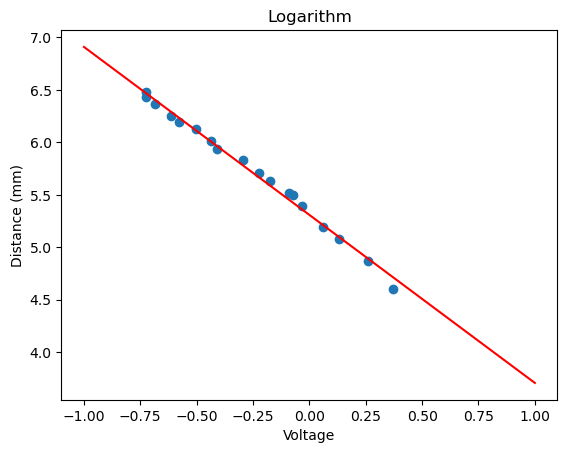

In [195]:
lin = np.linspace(-1, 1)
y_lin = a * lin + b

figure()

scatter(log_voltages, log_distances)
plot(lin, y_lin, 'r')

title("Logarithm")
ylabel("Distance (mm)")
xlabel("Voltage")
show()

Wir rechnen die lineare regression in eine exponentielle regression um indem wir $y = e^b * x^a$ anwenden.


In [196]:
def messungs_funktion(x):
    return np.exp(b) * x ** a

def dx_messungs_funktion(x):
    return a * np.exp(b) * x**(a-1)

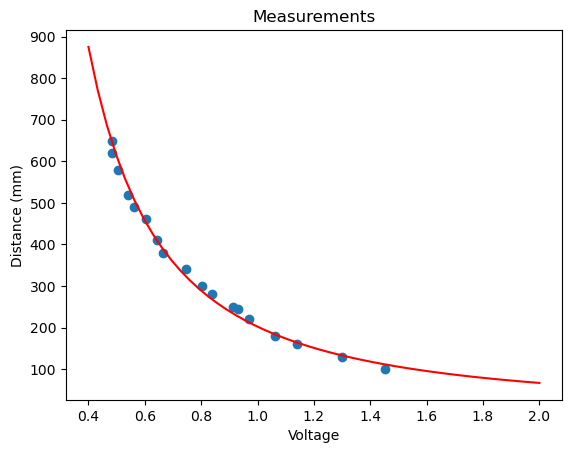

In [197]:
xc = np.linspace(0.4, 2)
yc = messungs_funktion(xc)
figure()
scatter(voltages, distances)
plot(xc, yc, 'r')
title("Measurements")
ylabel("Distance (mm)")
xlabel("Voltage")
show()

# Fehlerrechnung


In [198]:
def stdmean(x):
    return np.std(x) / np.sqrt(x.size)

In [199]:
# wahrer wert
dina4_breite_mm = 210

# gemessene werte
measured_dina4_breite = read_ps_voltage("./cleaned/dina4_breite_cleaned.csv")
measured_dina4_breite_mean = np.mean(measured_dina4_breite)
measured_dina4_breite_stdmean = stdmean(measured_dina4_breite)

In [200]:
dina4_hoehe_mm = 297
measured_dina4_hoehe = read_ps_voltage("./cleaned/dina4_hoehe_cleaned.csv")
measured_dina4_hoehe_mean = np.mean(measured_dina4_hoehe)

## Messfehler


delta_x = -3.981283612043569 mm
delta_y = 1328.8384742982803 mm


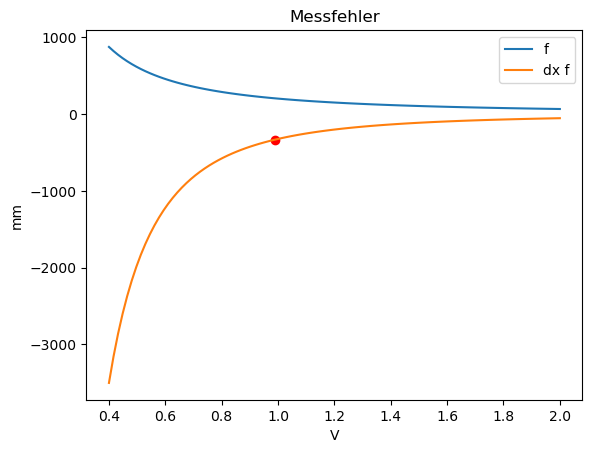

In [208]:
# 04-13 verwenden
x = measured_dina4_breite_mean
measured_breite = messungs_funktion(x)
delta_x = measured_breite - dina4_breite_mm
print("delta_x =", delta_x, "mm")

delta_y = dx_messungs_funktion(x) * delta_x
print("delta_y =", delta_y, "mm")

figure()
title("Messfehler")
ylabel("mm")
xlabel("V")
xc = linspace(0.4, 2, 100)
plot(xc, messungs_funktion(xc), label="f")
plot(xc, dx_messungs_funktion(xc), label="dx f")
scatter(x, dx_messungs_funktion(x), color='r')
legend()
show()

### 68 % Vertrauensbereich


In [202]:
gauss_68 = measured_dina4_breite_stdmean
print("+-", str(gauss_68), "V")

def sicherheit_65(x):
    return (np.mean(x) + 1.03 * stdmean(x), np.mean(x) - 1.03 * stdmean(x))

print(sicherheit_65(measured_dina4_breite))

+- 0.00021179505854358662 V
(0.9879949433436997, 0.9875586455230999)


### 95 % Vertrauensbereich


In [203]:
gauss_95 = 2 * measured_dina4_breite_stdmean
print("+-", str(gauss_95), "V")

def sicherheit_95(x):
    return (np.mean(x) + 2.09 * stdmean(x), np.mean(x) - 2.09 * stdmean(x))

print(sicherheit_95(measured_dina4_breite))

+- 0.00042359011708717324 V
(0.988219446105756, 0.9873341427610437)


## Flächenmessung

Ein DIN A4 Blatt hat das Format $297 mm * 210 mm$

Die fläche sollte $62370mm^2$.


In [204]:
estimated_width = messungs_funktion(measured_dina4_breite_mean)
estimated_height = estimated_width * 1.4142 
flaeche = estimated_width * estimated_height
print("Fläche:", flaeche, "mm^2")
# höhe messunge verwenden
# Fehlerfortpflanzungsgesetz

Fläche: 60023.89680632811 mm^2
